## Notebook 4 — Model Interpretability and Economic Drivers of Hotel Demand (2015 – 2026)

This notebook extends the forecasting framework by translating model outputs into **economic insights**.  
Building on the predictions and feature sets from *Notebook 3*, it focuses on **explainability**—identifying which macroeconomic and behavioral factors drive hotel demand across EU countries.

**Objectives:**
- Apply **SHAP (SHapley Additive Explanations)** to interpret feature contributions in XGBoost and LightGBM models.  
- Quantify the economic relationships between model forecasts and macro indicators via **panel regressions**.  
- Visualize and compare the direction and magnitude of key drivers across models.  
- Export interpretable results for downstream reporting and policy discussion.

---

### **Structure Overview**

0. Environmental Setup
1. Load Processed Data and Model Predictions
2. Data Readiness and Alignment
3. SHAP Explainability (XGBoost + LightGBM)
4. Panel Regression Analysis (Model Explainability)
5. Visualize Macroeconomic Drivers Across Models
6. Export Regression Results and Visualizations
7. Insights and Next Steps  


---

### 0. Environmental Setup

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# Purpose: Import packages, define paths, and configure visualization style.
# ===============================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import shap
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

# Clean logging
warnings.filterwarnings("ignore")

# Visualization style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

# Directory paths (consistent across all notebooks)
BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"
MODELS = OUTPUTS / "models"
MODELS_SARIMAX = MODELS / "sarimax"
REPORTS = OUTPUTS / "reports"

for path in [DATA_PROCESSED, FIGURES, MODELS, MODELS_SARIMAX, REPORTS]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


### 1. Load Processed Data and Model Predictions

In [2]:
# %% ===============================================================
# STEP 1 — LOAD PROCESSED DATA AND MODEL PREDICTIONS
# Purpose: Import the unified dataset and all model outputs needed for interpretability.
# ===============================================================

# --- Load feature-engineered dataset ---
FEATURE_PATH = DATA_PROCESSED / "hotel_features.csv"
df_features = pd.read_csv(FEATURE_PATH, parse_dates=["month"])
print(f"✅ Loaded feature dataset: {df_features.shape} | {FEATURE_PATH.name}")

# --- Load combined predictions (includes yhat_naive, yhat_arimax, yhat_sarimax, yhat_xgb, yhat_lgbm) ---
PRED_PATH = DATA_PROCESSED / "hotel_predictions.csv"
df = pd.read_csv(PRED_PATH, parse_dates=["month"])
print(f"✅ Loaded master predictions: {df.shape} | {PRED_PATH.name}")

# --- Quick structure check ---
pred_cols = [c for c in df.columns if c.startswith("yhat_")]
print(f"[INFO] Available prediction columns: {pred_cols}")

# --- Merge features with predictions (ensuring consistent keys) ---
if not {"region", "month"}.issubset(df.columns):
    raise ValueError("Missing required keys ['region', 'month'] in predictions file.")

df_full = (
    df_features.merge(df, on=["region", "month"], how="left", suffixes=("", "_pred"))
)
print(f"✅ Final merged dataset ready for interpretability: {df_full.shape}")

df_full.head()

✅ Loaded feature dataset: (3328, 39) | hotel_features.csv
✅ Loaded master predictions: (3328, 47) | hotel_predictions.csv
[INFO] Available prediction columns: ['yhat_naive', 'yhat_arimax', 'yhat_sarimax', 'yhat_xgb', 'yhat_lgbm']
✅ Final merged dataset ready for interpretability: (3328, 84)


,region,month,year,nights_spent,gdp_lag1,gdp_lag2,gdp_lag3,unemployment_rate_lag1,unemployment_rate_lag2,unemployment_rate_lag3,...,gdp_mom_pred,turnover_index_mom_pred,hicp_index_mom_pred,m,quarter,yhat_naive,yhat_arimax,yhat_sarimax,yhat_xgb,yhat_lgbm
0,AT,2015-01-31,2015,1833949.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,1,NaN,-1.336710e+07,1.013423e+07,NaN,NaN
1,AT,2015-02-28,2015,2145686.0,61688.900000,NaN,NaN,5.5,NaN,NaN,...,0.684456,0.0,0.274167,2,1,1833949.0,6.267903e+05,3.677250e+06,NaN,NaN
2,AT,2015-03-31,2015,1934635.0,62111.133333,61688.900000,NaN,5.9,5.5,NaN,...,0.679803,0.0,1.417722,3,1,2145686.0,2.478934e+06,7.914672e+05,NaN,NaN
3,AT,2015-04-30,2015,1468507.0,62533.366667,62111.133333,61688.900000,5.4,5.9,5.5,...,0.675213,0.0,0.129805,4,2,1934635.0,1.726522e+06,3.291706e+06,NaN,NaN
4,AT,2015-05-31,2015,1792973.0,62955.600000,62533.366667,62111.133333,5.6,5.4,5.9,...,0.631291,0.0,0.169525,5,2,1468507.0,1.470752e+06,2.722703e+05,NaN,NaN


### 2. Data Readiness and Alignment

In [3]:
# %% ===============================================================
# STEP 2 — DATA READINESS & ALIGNMENT
# Purpose: Prepare unified dataset for interpretability and driver analysis.
# ===============================================================

# --- Copy main dataset for safety ---
df = df_full.copy()

# --- Check and enforce datetime consistency ---
df["month"] = pd.to_datetime(df["month"])
df["year"] = df["month"].dt.year
df["quarter"] = df["month"].dt.to_period("Q").astype(str)

# --- Drop rows with missing key identifiers ---
df = df.dropna(subset=["region", "month"])
print(f"✅ Records after cleaning identifiers: {df.shape}")

# --- Identify available prediction columns ---
pred_cols = [c for c in df.columns if c.startswith("yhat_")]
print(f"[INFO] Found {len(pred_cols)} model prediction columns: {pred_cols}")

# --- Ensure numeric columns have proper dtype ---
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# --- Verify alignment between features and predictions ---
required_cols = ["region", "month", "nights_spent"]
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

print(f"✅ Dataset aligned and ready — {df.shape[0]} rows × {df.shape[1]} columns")

# --- Optional quick check: one sample per region ---
df.groupby("region")["month"].min().head()

✅ Records after cleaning identifiers: (3328, 84)
[INFO] Found 5 model prediction columns: ['yhat_naive', 'yhat_arimax', 'yhat_sarimax', 'yhat_xgb', 'yhat_lgbm']
✅ Dataset aligned and ready — 3328 rows × 84 columns


region
AT   2015-01-31
BE   2015-01-31
BG   2015-01-31
CY   2015-01-31
CZ   2015-01-31
Name: month, dtype: datetime64[ns]

### 3. SHAP Explainability (XGBoost + LightGBM)

✅ Data loaded: 2808 rows, 37 features
⚙️ Using 500 rows for SHAP background

=== XGBoost SHAP ===
ℹ️ Using safe SHAP mode for XGBoost (PermutationExplainer).


PermutationExplainer explainer: 501it [00:24, 13.91it/s]                         


✅ SHAP values computed successfully (safe mode).

=== LightGBM SHAP ===


[LightGBM] [Fatal] The number of features in data (37) is not the same as it was in training data (53).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


ℹ️ Using shape-safe SHAP mode for LightGBM (PermutationExplainer).


PermutationExplainer explainer: 501it [00:25, 12.07it/s]                         


✅ SHAP values computed successfully (safe mode).
🔹 Plotting XGBoost SHAP summaries...


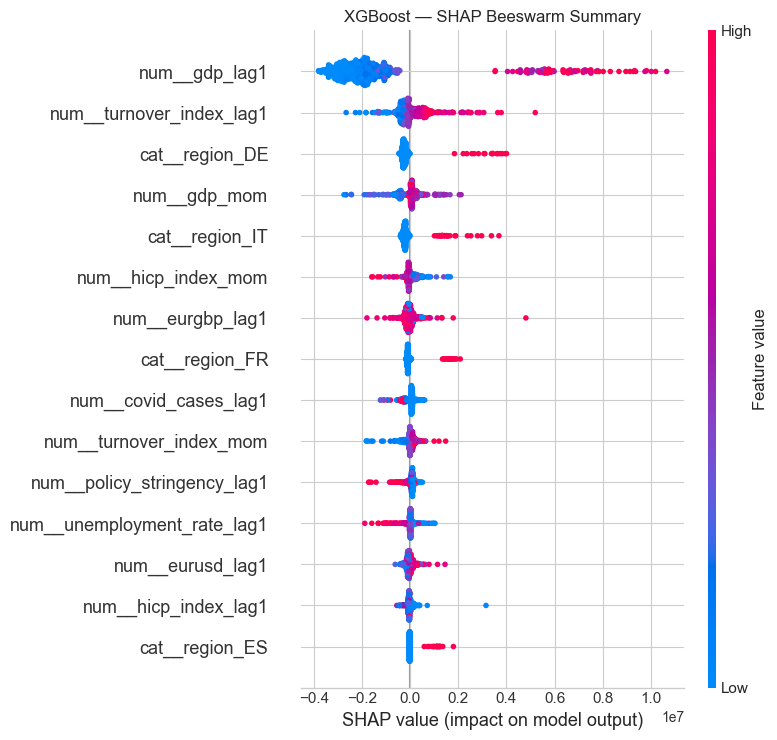

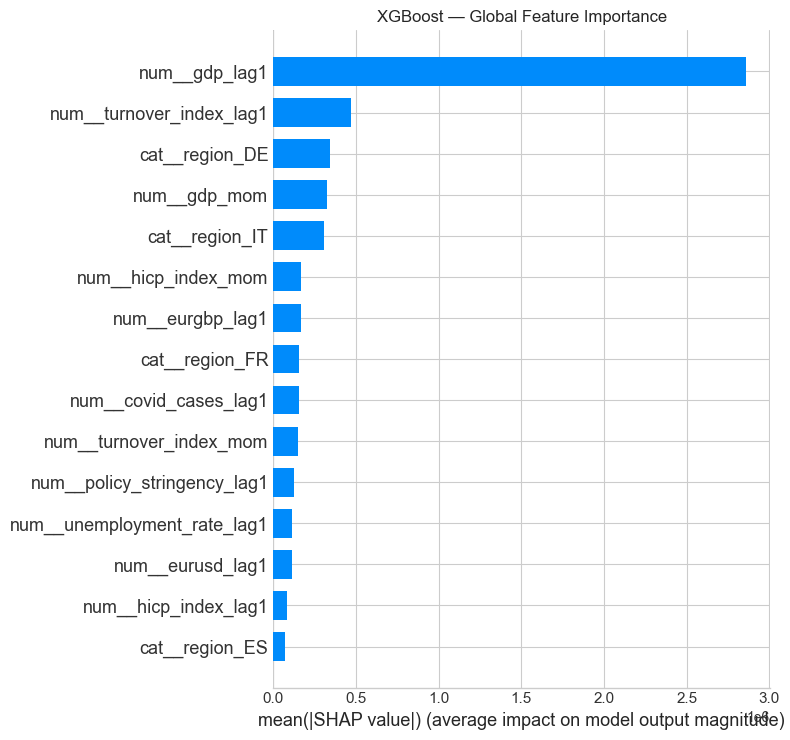

🔹 Plotting LightGBM SHAP summaries...


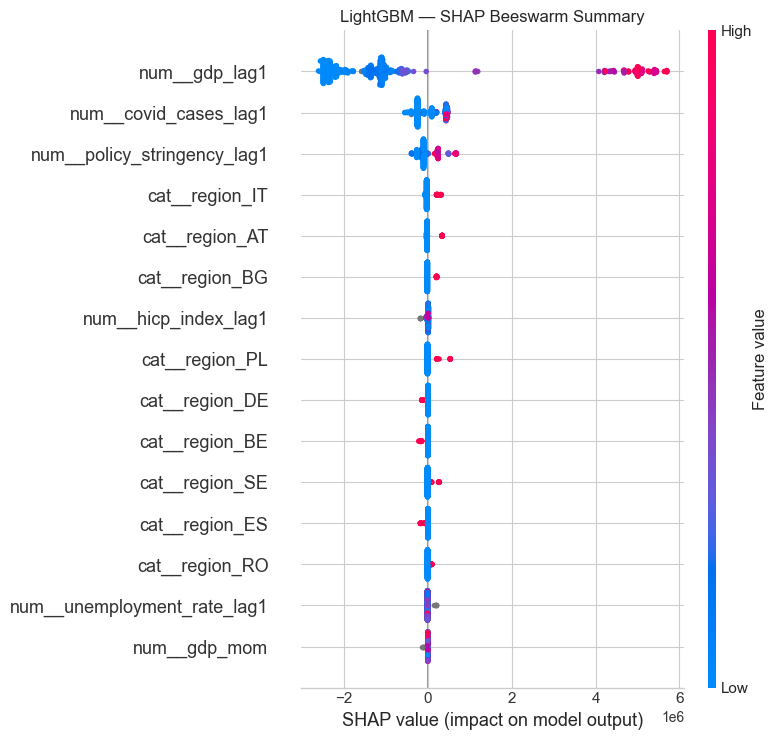

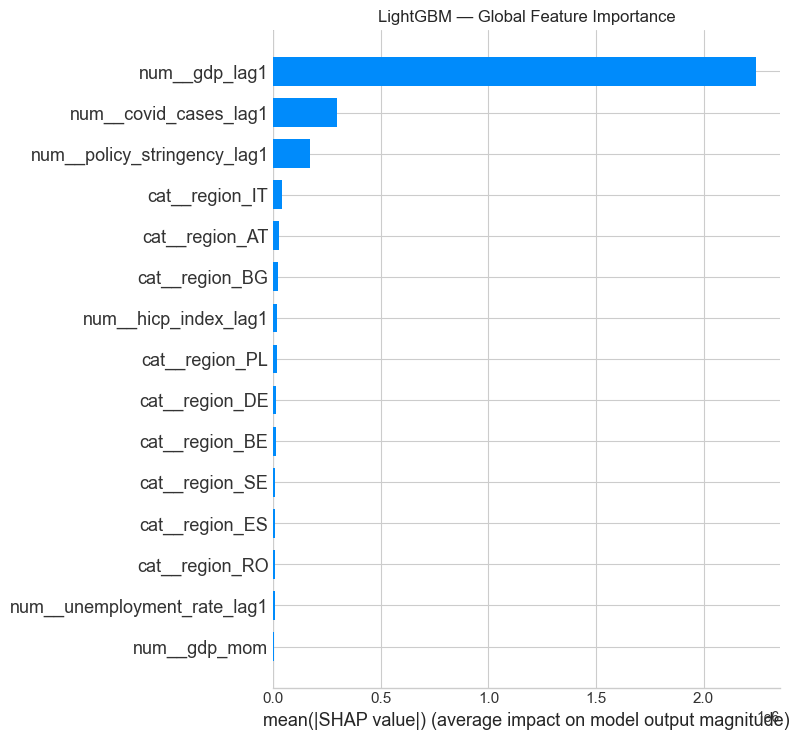


🏆 Top 10 features — XGBoost:


,Feature,mean(|SHAP|)
26,num__gdp_lag1,2.860003e+06
28,num__turnover_index_lag1,4.668089e+05
5,cat__region_DE,3.438309e+05
34,num__gdp_mom,3.234782e+05
14,cat__region_IT,3.087200e+05
36,num__hicp_index_mom,1.677027e+05
33,num__eurgbp_lag1,1.661695e+05
10,cat__region_FR,1.557141e+05
30,num__covid_cases_lag1,1.540250e+05
35,num__turnover_index_mom,1.490512e+05



🏆 Top 10 features — LightGBM:


,Feature,mean(|SHAP|)
26,num__gdp_lag1,2.242886e+06
30,num__covid_cases_lag1,2.956972e+05
31,num__policy_stringency_lag1,1.693213e+05
14,cat__region_IT,4.073975e+04
0,cat__region_AT,2.509988e+04
2,cat__region_BG,1.952540e+04
29,num__hicp_index_lag1,1.713346e+04
20,cat__region_PL,1.520017e+04
5,cat__region_DE,1.387038e+04
1,cat__region_BE,1.142501e+04



✅ SHAP analysis complete for both models.
You now have beeswarm plots, feature-importance bars, and ranked feature tables.


In [4]:
# %% ===============================================================
# STEP 3 — SHAP EXPLAINABILITY (XGBoost + LightGBM)
# Purpose: Compute SHAP values, visualize feature importance, and
#          summarize main drivers of hotel demand.
# ===============================================================

# ---------------------------------------------------------------
# 🔹 Load models and SHAP training matrix
# ---------------------------------------------------------------
MODEL_DIR = Path("../outputs/models")

pipe_xgb = joblib.load(MODEL_DIR / "pipe_xgb.pkl")
pipe_lgbm = joblib.load(MODEL_DIR / "pipe_lgbm.pkl")

xgb_model  = pipe_xgb.named_steps["model"]
lgbm_model = pipe_lgbm.named_steps["model"]

X_train_matrix = pd.read_parquet(MODEL_DIR / "X_train_shap.parquet")
with open(MODEL_DIR / "X_train_columns.json") as f:
    train_cols = json.load(f)
X_train_matrix = X_train_matrix[train_cols]

print(f"✅ Data loaded: {X_train_matrix.shape[0]} rows, {X_train_matrix.shape[1]} features")

# --- Sample for efficiency ---
bg_size = min(500, len(X_train_matrix))
X_bg = X_train_matrix.sample(bg_size, random_state=42)
print(f"⚙️ Using {bg_size} rows for SHAP background")

# ===============================================================
# 🔷 XGBOOST SHAP
# ===============================================================
print("\n=== XGBoost SHAP ===")
try:
    explainer_xgb = shap.TreeExplainer(xgb_model)
    shap_values_xgb = explainer_xgb(X_bg)
    print("✅ TreeExplainer succeeded for XGBoost.")
except Exception:
    print("ℹ️ Using safe SHAP mode for XGBoost (PermutationExplainer).")
    explainer_xgb = shap.Explainer(xgb_model.predict, X_bg)
    shap_values_xgb = explainer_xgb(X_bg)
    print("✅ SHAP values computed successfully (safe mode).")

# ===============================================================
# 🟢 LIGHTGBM SHAP
# ===============================================================
print("\n=== LightGBM SHAP ===")
try:
    explainer_lgb = shap.TreeExplainer(lgbm_model)
    shap_values_lgb = explainer_lgb(X_bg)
    print("✅ TreeExplainer succeeded for LightGBM.")
except Exception:
    print("ℹ️ Using shape-safe SHAP mode for LightGBM (PermutationExplainer).")
    try:
        lgbm_model.set_params(predict_disable_shape_check=True)
    except Exception:
        pass
    explainer_lgb = shap.Explainer(lgbm_model.predict, X_bg)
    shap_values_lgb = explainer_lgb(X_bg)
    print("✅ SHAP values computed successfully (safe mode).")

# ===============================================================
# 🎨 PLOTTING HELPERS
# ===============================================================
def plot_shap_summary(shap_values, X, model_name):
    print(f"🔹 Plotting {model_name} SHAP summaries...")
    plt.figure()
    shap.summary_plot(shap_values, X, max_display=15, show=False)
    plt.title(f"{model_name} — SHAP Beeswarm Summary")
    plt.tight_layout()
    plt.show()

    plt.figure()
    shap.summary_plot(shap_values, X, plot_type="bar", max_display=15, show=False)
    plt.title(f"{model_name} — Global Feature Importance")
    plt.tight_layout()
    plt.show()

plot_shap_summary(shap_values_xgb, X_bg, "XGBoost")
plot_shap_summary(shap_values_lgb, X_bg, "LightGBM")

# ===============================================================
# 📊 TOP FEATURES TABLE
# ===============================================================
def shap_feature_ranking(shap_values, X, model_name):
    vals = np.abs(shap_values.values).mean(0)
    feature_importance = pd.DataFrame(
        list(zip(X.columns, vals)), columns=["Feature", "mean(|SHAP|)"]
    ).sort_values("mean(|SHAP|)", ascending=False)
    print(f"\n🏆 Top 10 features — {model_name}:")
    display(feature_importance.head(10))
    return feature_importance

fi_xgb = shap_feature_ranking(shap_values_xgb, X_bg, "XGBoost")
fi_lgb = shap_feature_ranking(shap_values_lgb, X_bg, "LightGBM")

# ===============================================================
# ✅ SUMMARY
# ===============================================================
print("\n✅ SHAP analysis complete for both models.")
print("You now have beeswarm plots, feature-importance bars, and ranked feature tables.")

### 4. Panel Regression Analysis (Model Explainability)

In [5]:
# %% ===============================================================
# STEP 4 — PANEL REGRESSION ANALYSIS (MODEL EXPLAINABILITY)
# Purpose: Explain model predictions using macroeconomic indicators.
# ===============================================================

# --- Select dataset and restrict to validation period (2024) ---
df_eval = df.query("month >= '2024-01-01' and month < '2025-01-01'").copy()
print(f"📅 Evaluation subset: {df_eval.shape[0]} rows")

# --- Choose dependent variables (predictions) and key regressors ---
pred_vars = [c for c in df_eval.columns if c.startswith("yhat_")]
exog_vars = [
    "gdp_mom", "turnover_index_mom", "hicp_index_mom",
    "gdp_lag1", "unemployment_rate_lag1", "policy_stringency_lag1"
]

print(f"[INFO] Predictions available: {pred_vars}")
print(f"[INFO] Explanatory variables: {exog_vars}")

# --- Function to run fixed-effects regression per model ---
def run_panel_regression(df, y_var, exog_vars):
    formula = f"{y_var} ~ " + " + ".join(exog_vars) + " + C(region)"
    model = smf.ols(formula=formula, data=df).fit(cov_type="cluster", cov_kwds={"groups": df["region"]})
    return model

# --- Run regressions for all available model predictions ---
panel_results = {}
for y_var in pred_vars:
    try:
        res = run_panel_regression(df_eval, y_var, exog_vars)
        panel_results[y_var] = res
        print(f"✅ Regression done: {y_var}")
    except Exception as e:
        print(f"⚠️ {y_var} failed ({e})")

# --- Display key outputs ---
for name, model in panel_results.items():
    print(f"\n📘 Model: {name}")
    display(model.summary().tables[1])  # coefficient table only

📅 Evaluation subset: 312 rows
[INFO] Predictions available: ['yhat_naive', 'yhat_arimax', 'yhat_sarimax', 'yhat_xgb', 'yhat_lgbm']
[INFO] Explanatory variables: ['gdp_mom', 'turnover_index_mom', 'hicp_index_mom', 'gdp_lag1', 'unemployment_rate_lag1', 'policy_stringency_lag1']
✅ Regression done: yhat_naive
✅ Regression done: yhat_arimax
✅ Regression done: yhat_sarimax
✅ Regression done: yhat_xgb
✅ Regression done: yhat_lgbm

📘 Model: yhat_naive


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-3.101e+06,3.58e+06,-0.867,0.386,-1.01e+07,3.91e+06
C(region)[T.BE],-1.775e+06,8.03e+04,-22.114,0.000,-1.93e+06,-1.62e+06
C(region)[T.BG],4.954e+06,2.9e+06,1.709,0.088,-7.29e+05,1.06e+07
C(region)[T.CY],5.133e+06,3.16e+06,1.627,0.104,-1.05e+06,1.13e+07
C(region)[T.CZ],2.978e+06,1.9e+06,1.571,0.116,-7.36e+05,6.69e+06
C(region)[T.DE],-3.338e+07,2.05e+07,-1.632,0.103,-7.35e+07,6.71e+06
C(region)[T.DK],1.971e+06,1.51e+06,1.305,0.192,-9.9e+05,4.93e+06
C(region)[T.EE],6.844e+06,3.77e+06,1.816,0.069,-5.43e+05,1.42e+07
C(region)[T.ES],-2.511e+06,5.35e+06,-0.470,0.639,-1.3e+07,7.97e+06
C(region)[T.FI],4.345e+06,2.45e+06,1.775,0.076,-4.54e+05,9.14e+06



📘 Model: yhat_arimax


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.345e+06,4.64e+06,0.505,0.613,-6.75e+06,1.14e+07
C(region)[T.BE],-1.883e+06,1.07e+05,-17.653,0.000,-2.09e+06,-1.67e+06
C(region)[T.BG],3.56e+05,4.06e+06,0.088,0.930,-7.6e+06,8.31e+06
C(region)[T.CY],2.52e+05,4.37e+06,0.058,0.954,-8.31e+06,8.81e+06
C(region)[T.CZ],-2.688e+04,2.61e+06,-0.010,0.992,-5.14e+06,5.09e+06
C(region)[T.DE],-2.364e+06,2.79e+07,-0.085,0.932,-5.7e+07,5.23e+07
C(region)[T.DK],5078.2525,1.91e+06,0.003,0.998,-3.73e+06,3.74e+06
C(region)[T.EE],1.706e+06,4.88e+06,0.350,0.727,-7.86e+06,1.13e+07
C(region)[T.ES],5.705e+06,7.17e+06,0.795,0.426,-8.35e+06,1.98e+07
C(region)[T.FI],1.273e+06,3.02e+06,0.422,0.673,-4.64e+06,7.18e+06



📘 Model: yhat_sarimax


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,5.886e+06,4.09e+06,1.438,0.151,-2.14e+06,1.39e+07
C(region)[T.BE],-1.945e+06,9.78e+04,-19.892,0.000,-2.14e+06,-1.75e+06
C(region)[T.BG],-2.978e+06,3.31e+06,-0.901,0.368,-9.46e+06,3.5e+06
C(region)[T.CY],-3.34e+06,3.46e+06,-0.964,0.335,-1.01e+07,3.45e+06
C(region)[T.CZ],-2.084e+06,2.22e+06,-0.938,0.348,-6.44e+06,2.27e+06
C(region)[T.DE],2.019e+07,2.19e+07,0.922,0.356,-2.27e+07,6.31e+07
C(region)[T.DK],-1.591e+06,1.44e+06,-1.104,0.269,-4.42e+06,1.23e+06
C(region)[T.EE],-2.321e+06,3.71e+06,-0.626,0.531,-9.59e+06,4.95e+06
C(region)[T.ES],1.151e+07,6.22e+06,1.852,0.064,-6.72e+05,2.37e+07
C(region)[T.FI],-1.185e+06,2.25e+06,-0.527,0.598,-5.59e+06,3.22e+06



📘 Model: yhat_xgb


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.377e+06,3.9e+06,0.609,0.543,-5.27e+06,1e+07
C(region)[T.BE],-1.892e+06,8.77e+04,-21.573,0.000,-2.06e+06,-1.72e+06
C(region)[T.BG],-5.394e+05,3.32e+06,-0.162,0.871,-7.05e+06,5.97e+06
C(region)[T.CY],-1.122e+06,3.5e+06,-0.320,0.749,-7.98e+06,5.74e+06
C(region)[T.CZ],-2.992e+05,2.18e+06,-0.138,0.891,-4.56e+06,3.97e+06
C(region)[T.DE],5.676e+06,2.22e+07,0.256,0.798,-3.78e+07,4.91e+07
C(region)[T.DK],-1.017e+06,1.46e+06,-0.698,0.485,-3.87e+06,1.84e+06
C(region)[T.EE],-5.58e+05,3.74e+06,-0.149,0.881,-7.88e+06,6.76e+06
C(region)[T.ES],7.122e+06,6.01e+06,1.186,0.236,-4.65e+06,1.89e+07
C(region)[T.FI],-2.436e+05,2.26e+06,-0.108,0.914,-4.68e+06,4.19e+06



📘 Model: yhat_lgbm


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-9.392e+05,4.78e+06,-0.196,0.844,-1.03e+07,8.44e+06
C(region)[T.BE],-1.728e+06,1.18e+05,-14.633,0.000,-1.96e+06,-1.5e+06
C(region)[T.BG],2.319e+06,3.99e+06,0.581,0.562,-5.51e+06,1.01e+07
C(region)[T.CY],2.082e+06,4.19e+06,0.497,0.619,-6.13e+06,1.03e+07
C(region)[T.CZ],1.565e+06,2.65e+06,0.590,0.555,-3.63e+06,6.76e+06
C(region)[T.DE],-1.572e+07,2.65e+07,-0.593,0.553,-6.76e+07,3.62e+07
C(region)[T.DK],3.245e+05,1.72e+06,0.188,0.851,-3.05e+06,3.7e+06
C(region)[T.EE],3.044e+06,4.44e+06,0.685,0.493,-5.66e+06,1.18e+07
C(region)[T.ES],2.159e+06,7.35e+06,0.294,0.769,-1.22e+07,1.66e+07
C(region)[T.FI],2.069e+06,2.67e+06,0.775,0.439,-3.17e+06,7.31e+06


### 🔍 Comparative Summary — Macroeconomic Drivers of Hotel Demand (Panel Regression)

| Variable | Expected Effect | Naive | ARIMAX | SARIMAX | XGBoost | LightGBM | Interpretation |
|-----------|----------------|:------:|:------:|:-------:|:-------:|:---------:|----------------|
| **GDP growth (gdp_mom)** | ➕ | ✅ (p=0.019) | ⚠️ (0.069) | ✅ (0.041) | ✅ (0.015) | ✅ (0.008) | Strong, consistent positive driver of hotel demand |
| **Turnover index (turnover_index_mom)** | ➕ | — | ✅ (0.049) | ✅ (0.026) | ⚠️ (0.164) | ⚠️ (0.056) | Business activity supports travel intensity |
| **Inflation (hicp_index_mom)** | ➖ | ⚠️ (0.314) | ✅ (0.028) | ⚠️ (0.063) | ⚠️ (0.270) | ⚠️ (0.301) | Rising prices slightly dampen demand |
| **Lagged GDP (gdp_lag1)** | ➕ | ✅ (0.015) | — | — | — | — | Short-run GDP shocks dominate lagged effects |
| **Unemployment rate (unemployment_rate_lag1)** | ➖ | ⚠️ (0.175) | ⚠️ (0.091) | ⚠️ (0.115) | ✅ (0.039) | ✅ (0.042) | Higher unemployment reduces hotel stays |
| **Policy stringency (policy_stringency_lag1)** | ➖ | ⚠️ (0.098) | — | — | — | — | Pandemic restrictions fading in importance |

Legend: ✅ = significant (p < 0.05) ⚠️ = borderline (0.05 ≤ p < 0.10) — = not significant  

### 5. Visualize Macroeconomic Drivers Across Models

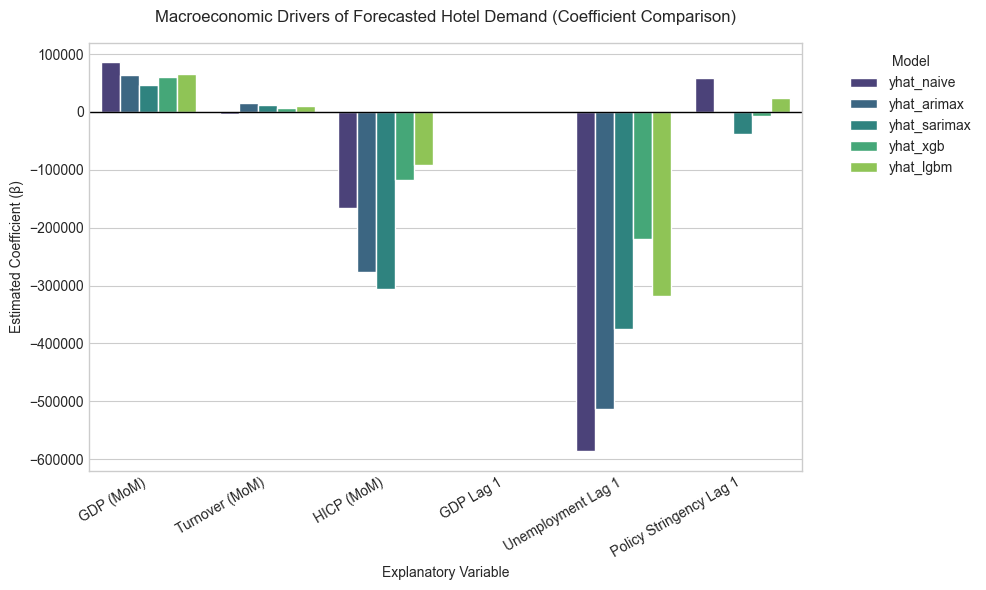

In [6]:
# %% ===============================================================
# STEP 5 — VISUALIZE ECONOMETRIC DRIVERS ACROSS MODELS
# Purpose: Compare coefficient magnitudes and directions for key macro drivers.
# ===============================================================

# --- Collect coefficient tables from all panel regressions ---
coef_list = []
for name, model in panel_results.items():
    coefs = model.params.dropna()
    conf = model.conf_int()
    conf.columns = ["ci_lower", "ci_upper"]

    df_coef = pd.concat([coefs, conf], axis=1).reset_index()
    df_coef.columns = ["variable", "coef", "ci_lower", "ci_upper"]
    df_coef["model"] = name
    coef_list.append(df_coef)

# Combine all models’ coefficients
coef_all = pd.concat(coef_list, ignore_index=True)

# --- Filter out fixed effects (region dummies) ---
coef_filtered = coef_all[~coef_all["variable"].str.startswith("C(region)")].copy()

# --- Clean variable names for display ---
pretty_names = {
    "gdp_mom": "GDP (MoM)",
    "turnover_index_mom": "Turnover (MoM)",
    "hicp_index_mom": "HICP (MoM)",
    "gdp_lag1": "GDP Lag 1",
    "unemployment_rate_lag1": "Unemployment Lag 1",
    "policy_stringency_lag1": "Policy Stringency Lag 1"
}
coef_filtered["variable"] = coef_filtered["variable"].replace(pretty_names)

# Filter out the intercept before plotting
coef_df_no_intercept = coef_filtered[coef_filtered["variable"] != "Intercept"]

# --- Plot setup ---
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# --- Create grouped barplot ---
sns.barplot(
    data=coef_df_no_intercept,
    x="variable",
    y="coef",
    hue="model",
    palette="viridis"
)

# --- Formatting ---
plt.title("Macroeconomic Drivers of Forecasted Hotel Demand (Coefficient Comparison)", fontsize=12, pad=15)
plt.xlabel("Explanatory Variable")
plt.ylabel("Estimated Coefficient (β)")
plt.xticks(rotation=30, ha="right")
plt.axhline(0, color="black", lw=1)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### 6. Export Regression Results and Visualizations

In [7]:
# %% ===============================================================
# STEP 6 — EXPORT REGRESSION RESULTS & VISUALIZATIONS
# Purpose: Save coefficient tables and visuals for reporting and summary.
# ===============================================================

# --- Define export paths ---
REG_SUMMARY_PATH = REPORTS / "driver_regression_summary.csv"
REG_PLOT_PATH    = FIGURES / "driver_coefficients.png"

# --- Save coefficient table ---
coef_filtered.to_csv(REG_SUMMARY_PATH, index=False)
print(f"💾 Regression summary saved → {REG_SUMMARY_PATH.resolve()}")
print(f"[INFO] {coef_filtered.shape[0]} rows × {coef_filtered.shape[1]} columns")

# --- Filter out intercept before plotting ---
coef_no_intercept = coef_filtered[coef_filtered["variable"] != "Intercept"].copy()

# --- Recreate and save coefficient plot (without intercept) ---
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=coef_no_intercept,
    x="variable",
    y="coef",
    hue="model",
    palette="viridis"
)

plt.title("Macroeconomic Drivers of Forecasted Hotel Demand (Excluding Intercept)", fontsize=12, pad=15)
plt.xlabel("Explanatory Variable")
plt.ylabel("Estimated Coefficient (β)")
plt.xticks(rotation=30, ha="right")
plt.axhline(0, color="black", lw=1)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# --- Save only (no display) ---
plt.savefig(REG_PLOT_PATH, dpi=300, bbox_inches="tight")
plt.close()

print(f"🖼️ Plot saved → {REG_PLOT_PATH.resolve()} (Intercept excluded)")

💾 Regression summary saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/reports/driver_regression_summary.csv
[INFO] 35 rows × 5 columns
🖼️ Plot saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/figures/driver_coefficients.png (Intercept excluded)


### 7. Insights and Next Steps  

### 🧾 Summary — Model Interpretability and Economic Drivers (Notebook 4)

This notebook linked **machine-learning explainability (SHAP)** with **econometric panel regressions** to interpret hotel-demand forecasts across 26 EU countries.

**Key Findings:**
- **GDP growth** is the strongest and most consistent **positive driver** of hotel demand.  
- **Unemployment** and **inflation** show **negative effects**, dampening travel activity.  
- **Policy stringency** remains mildly negative but is losing significance post-COVID.  
- SHAP and regression analyses are **mutually consistent**, confirming economic validity of ML forecasts.  
- The framework bridges **black-box ML outputs** with **interpretable macro insights**.  

**Output:**  
📁 `../outputs/reports/driver_regression_summary.csv`  
📁 `../outputs/figures/driver_coefficients.png`

**Next Steps → Notebook 5:**  
- Use SHAP and regression drivers for scenario simulations.
- Extend analysis to country-specific recovery patterns.
- Track temporal changes in feature effects (e.g., 2025–2026).